# Imports

In [2]:
import os
import numpy as np
os.environ['ARROW_PRE_0_15_IPC_FORMAT'] = '1'

from data.importer import import_data
from util import pretty_evaluation, Stage
from cross_validate import cross_validate, cv_metrics
from preprocessor.features_store import FeatureStore

## Feature store

In [3]:
import os
import databricks.koalas as ks
from typing import Dict

from preprocessor.time.hashtag_popularity import hashtag_popularity
from preprocessor.time.user_activity import user_activity

from preprocessor.targets.binarize_timestamps import binarize_timestamps  # noqa: F401
# from preprocessor.graph.engaging_user_degree import engaging_user_degree

# from preprocessor.graph.auxiliary_engagement_graph import (
#     auxiliary_engagement_graph,
# )  # noqa: F401

class FeatureStore:
    """Handle feature configuration"""

    def __init__(
        self,
        path_preprocessed,
        enabled_extractors,
        path_auxiliaries,
        enabled_auxiliaries,
        raw_data,
        is_cluster,
        is_inference,
    ):
        """

        Args:
            path_preprocessed (str): materialized features files location
            enabled_extractors (list): list of the enabled feature extractors
            path_auxiliaries (str): materialized auxiliary data location
            enabled_auxiliaries (list): list of enabled auxiliary sources
            raw_data (ks.Dataframe): reference to raw data Dataframe instance
            is_cluster (bool): True if working on cluster, False if working on
                local machine
            is_inference (bool): True if inference time, False if training time
        """
        self.path_preprocessed = path_preprocessed
        self.path_auxiliaries = path_auxiliaries
        self.raw_data = raw_data
        self.is_cluster = is_cluster
        self.is_inference = is_inference

        self.enabled_auxiliaries = enabled_auxiliaries

        self.enabled_features = {"default": [], "custom": []}
        for feature in enabled_extractors:
            if feature in self.raw_data.columns:
                self.enabled_features["default"].append(feature)
            else:
                self.enabled_features["custom"].append(feature)

    def extract_auxiliaries(self):
        """
        Rationale: some features require additional data to be materialized.
        For instance, social network-related features require a graph
        representation of engagements, i.e., an additional DataFrame besides
        raw data and previously extracted features.

        Auxiliary data does not necessarily follow 1:1 correspondence between
        its rows and raw data rows.

        The same auxiliary data source may be exploited to extract multiple
        features.

        It is possible to use auxiliary data sources, pre-built on the training
        set, also at inference time, given that the auxiliary data source is not
        excessively large (still need to define what "too large" means, though
        we have ~20GB at our disposal on the test VM).
        """

        auxiliary_dict: Dict[str, ks.DataFrame] = {}

        for auxiliary_name in self.enabled_auxiliaries:
            auxiliary_path = os.path.join(self.path_auxiliaries, auxiliary_name)

            # If auxiliary data is already materialized
            if os.path.exists(auxiliary_path):
                print("### Reading cached auxiliary data " + auxiliary_name + "...")
                auxiliary_list = self.get_subdir_list(auxiliary_path)

                for key in auxiliary_list:
                    ks_auxiliary = ks.read_csv(
                        os.path.join(auxiliary_path, key), header=0
                    )
                    if isinstance(ks_auxiliary, ks.DataFrame):
                        auxiliary_dict[key] = ks_auxiliary
                    else:
                        raise TypeError(
                            f"ks_auxiliary must be a Koalas DataFrame, got {type(ks_auxiliary)}"
                        )

                # If inference time, and auxiliary data exists, it must be
                # extended with test data
                if self.is_inference:
                    print(
                        "### Integrating auxiliary data with test set "
                        + auxiliary_name
                        + "..."
                    )
                    auxiliary_extractor = globals()[auxiliary_name]
                    auxiliary_extracted = auxiliary_extractor(
                        self.raw_data, auxiliary_train=auxiliary_dict
                    )

                    if isinstance(auxiliary_extracted, dict):
                        for key in auxiliary_extracted:
                            assert isinstance(auxiliary_extracted[key], ks.DataFrame)
                            auxiliary_dict[key] = auxiliary_extracted[key]
                    else:
                        raise TypeError(
                            f"auxiliary_extracted must be a dict, got {type(auxiliary_extracted)}"
                        )

            else:
                print("### Extracting auxiliary data " + auxiliary_name + "...")
                auxiliary_extractor = globals()[auxiliary_name]
                auxiliary_extracted = auxiliary_extractor(self.raw_data)

                os.mkdir(auxiliary_path)
                if isinstance(auxiliary_extracted, dict):
                    for key in auxiliary_extracted:
                        assert isinstance(auxiliary_extracted[key], ks.DataFrame)
                        auxiliary_dict[key] = auxiliary_extracted[key]

                        auxiliary_extracted_path = os.path.join(auxiliary_path, key)

                        # Store the current auxiliary dataframe
                        auxiliary_extracted[key].to_csv(
                            auxiliary_extracted_path,
                            index_col=None,  # TODO (Manuele) how to handle index_col?
                            header=list(auxiliary_extracted[key].columns),
                            num_files=(None if self.is_cluster else 1),
                        )
                else:
                    raise TypeError(
                        f"auxiliary_extracted must be a dict, got {type(auxiliary_extracted)}"
                    )

                print("Auxiliary data added to " + auxiliary_path)

        return auxiliary_dict

    def extract_features(self):
        auxiliary_dict = self.extract_auxiliaries()

        feature_dict: Dict[str, ks.Series] = {}

        for feature_name in self.enabled_features["custom"]:
            feature_path = os.path.join(self.path_preprocessed, feature_name)

            # If feature already materialized
            if os.path.exists(feature_path):
                print("### Reading cached " + feature_name + "...")
                ks_feature = ks.read_csv(
                    feature_path, header=0, index_col=["tweet_id", "engaging_user_id"]
                )

                assert len(ks_feature) == len(self.raw_data)

                if isinstance(ks_feature, ks.DataFrame):
                    for column in ks_feature:
                        assert isinstance(ks_feature[column], ks.Series)
                        feature_dict[column] = ks_feature[column]
                elif isinstance(ks_feature, ks.Series):
                    feature_dict[feature_name] = ks_feature
                else:
                    raise TypeError(
                        f"ks_feature must be a Koalas DataFrame or Series, got {type(ks_feature)}"
                    )

            else:
                print("### Extracting " + feature_name + "...")
                feature_extractor = globals()[feature_name]

                extracted = feature_extractor(
                    self.raw_data, feature_dict, auxiliary_dict
                )

                if isinstance(extracted, dict):  # more than one feature extracted
                    for column in extracted:
                        assert isinstance(extracted[column], ks.Series)
                        feature_dict[column] = extracted[column]

                    # Store the new features
                    features_df = ks.concat(
                        list(extracted.values()), axis=1, join="inner"
                    )
                          
                    assert len(features_df) == len(list(extracted.values())[0])
                    
                    # TODO: fix this! Gives error with user activity
#                     features_df.to_csv(
#                         feature_path,
#                         index_col=["tweet_id", "engaging_user_id"],
#                         header=list(extracted.keys())
#                     )
                    
                elif isinstance(extracted, ks.Series):
                    feature_dict[feature_name] = extracted
                    extracted.to_csv(
                        feature_path,
                        index_col=["tweet_id", "engaging_user_id"],
                        header=[feature_name],
                        num_files=(None if self.is_cluster else 1),
                    )
                else:
                    raise TypeError(
                        f"extracted must be a Koalas DataFrame or Series, got {type(extracted)}"
                    )

                print("Feature added to " + feature_path)

        # Assign feature names to series
        for k in feature_dict:
            feature_dict[k].name = k

        return feature_dict

    def get_dataset(self):
        ks.set_option("compute.ops_on_diff_frames", True)

        feature_dict = self.extract_features()
        sliced_raw_data: ks.DataFrame = self.raw_data[self.enabled_features["default"]]
        features_dataset = sliced_raw_data

        # NOTE: I suppose this could be done in one pass, with a multiple inner join.
        # IDK if it would be faster
        for feature_name, feature_series in feature_dict.items():
            features_dataset = features_dataset.join(
                right=feature_series, on=["tweet_id", "engaging_user_id"], how="inner"
            )
        ks.set_option("compute.ops_on_diff_frames", False)

        # NOTE: the .sort_index is useful for having the rows always in the same
        # order. In this way the train_valid_test_split, which depends on the row's
        # order is the same regardless of how we joined. This allows for better
        # reproducibility and mental health.
        return features_dataset.sort_index()

    @staticmethod
    def get_subdir_list(path):
        subdirs = []
        for root, dirs, _ in os.walk(path):
            for dir_ in dirs:
                subdirs.append(dir_)
            break

        return subdirs


# Arguments

In [12]:
DATASET_PATH = "recsys-2021/data/raw/time_sample3M.parquet"
PATH_PREPROCESSED = "recsys-2021/data/preprocessed"
PATH_AUXILIARIES = "recsys-2021/data/auxiliary"
ENABLED_FEATURES = [
    "engaged_with_user_follower_count",
    "engaged_with_user_following_count",
    "engaging_user_follower_count",
    "engaging_user_following_count",
#     "user_activity",
    
    "binarize_timestamps"
]

ENABLED_AUXILIARY = []

# Model Training and Evaluation

In [6]:
with Stage("Importing data..."):
        raw_data = import_data(DATASET_PATH)

Importing data...
Done 9.59 seconds



In [13]:
with Stage("Assembling dataset..."):
    store = FeatureStore(
        PATH_PREPROCESSED,
        ENABLED_FEATURES,
        PATH_AUXILIARIES,
        ENABLED_AUXILIARY,
        raw_data,
        is_cluster=False,
        is_inference=False,
    )
    features_union_df = store.get_dataset()

Assembling dataset...
### Extracting binarize_timestamps...
Feature added to recsys-2021/data/preprocessed/binarize_timestamps
Done 36.53 seconds



In [14]:
%%time
params = {
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.7,
    'min_child_weight': 10, # increase if train-test-gap is large. More conservative but less overfitting
    'max_depth': 6,
    'seed': 42
}
    
cv_models, cv_results_train, cv_results_test = cross_validate(features_union_df, params, num_boost_round=13)

print("********************* TRAIN *********************")
for metric_lst in cv_metrics(cv_results_train):
    metric_lst = np.array(metric_lst)
    print(f"LB {(metric_lst.mean() - metric_lst.std()):+.4f} to UB {(metric_lst.mean() + metric_lst.std()):+.4f} (± 1σ)")

print("********************* TEST *********************")
for metric_lst in cv_metrics(cv_results_test):
    metric_lst = np.array(metric_lst)
    print(f"LB {(metric_lst.mean() - metric_lst.std()):+.4f} to UB {(metric_lst.mean() + metric_lst.std()):+.4f} (± 1σ)")

print(ENABLED_FEATURES)
print(params)

********************* TRAIN *********************
LB +0.1261 to UB +0.1372 (± 1σ)
LB -0.3522 to UB +0.2681 (± 1σ)
********************* TEST *********************
LB +0.1155 to UB +0.1194 (± 1σ)
LB -0.9987 to UB -0.5982 (± 1σ)
['engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaging_user_follower_count', 'engaging_user_following_count', 'binarize_timestamps']
{'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'subsample': 0.7, 'min_child_weight': 10, 'max_depth': 6, 'seed': 42}
CPU times: user 57min 23s, sys: 1min 53s, total: 59min 17s
Wall time: 4min 2s


3.5M Baseline:

`********************* TRAIN *********************
LB +0.1261 to UB +0.1372 (± 1σ)
LB -0.3522 to UB +0.2681 (± 1σ)
********************* TEST *********************
LB +0.1155 to UB +0.1194 (± 1σ)
LB -0.9987 to UB -0.5982 (± 1σ)
['engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaging_user_follower_count', 'engaging_user_following_count', 'binarize_timestamps']
{'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'subsample': 0.7, 'min_child_weight': 10, 'max_depth': 6, 'seed': 42}
CPU times: user 57min 23s, sys: 1min 53s, total: 59min 17s
Wall time: 4min 2s`

3.5M user_activity

`********************* TRAIN *********************
LB +0.1635 to UB +0.1706 (± 1σ)
LB +1.7293 to UB +2.2304 (± 1σ)
********************* TEST *********************
LB +0.1557 to UB +0.1609 (± 1σ)
LB +1.1716 to UB +1.5369 (± 1σ)
['engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaging_user_follower_count', 'engaging_user_following_count', 'user_activity', 'binarize_timestamps']
{'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'subsample': 0.7, 'min_child_weight': 10, 'max_depth': 6, 'seed': 42}
CPU times: user 1h 9s, sys: 2min 7s, total: 1h 2min 16s
Wall time: 5min 6s`

200k Baseline:

`********************* TRAIN *********************
LB +0.0896 to UB +0.1185 (± 1σ)
LB -1.2544 to UB +1.0046 (± 1σ)
********************* TEST *********************
LB +0.0582 to UB +0.0671 (± 1σ)
LB -5.0672 to UB -2.2738 (± 1σ)
['engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaging_user_follower_count', 'engaging_user_following_count', 'binarize_timestamps']
{'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'subsample': 0.7, 'min_child_weight': 10, 'max_depth': 6, 'seed': 42}
CPU times: user 8min 57s, sys: 15.8 s, total: 9min 12s
Wall time: 56.3 s`

200k with user_activity

`********************* TRAIN *********************
LB +0.1641 to UB +0.1937 (± 1σ)
LB +4.8041 to UB +7.3874 (± 1σ)
********************* TEST *********************
LB +0.1308 to UB +0.1401 (± 1σ)
LB +1.0433 to UB +3.3092 (± 1σ)
{'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'subsample': 0.7, 'min_child_weight': 10, 'max_depth': 6, 'seed': 42}
CPU times: user 9min 58s, sys: 19.3 s, total: 10min 17s
Wall time: 40.1 s`

200k with hashtag_popularity:

`********************* TRAIN *********************
LB +0.0912 to UB +0.1211 (± 1σ)
LB -1.0935 to UB +1.0804 (± 1σ)
********************* TEST *********************
LB +0.0594 to UB +0.0679 (± 1σ)
LB -4.9148 to UB -2.1439 (± 1σ)
{'tree_method': 'hist', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'subsample': 0.7, 'min_child_weight': 10, 'max_depth': 6, 'seed': 42}
CPU times: user 9min 4s, sys: 17 s, total: 9min 21s
Wall time: 1min 15s`

What the current top leaderboard submission looks like:
```
mAP:                        0.3115
mRCE:                      16.4698
```
Leaderboard: https://recsys-twitter.com/leaderboard/all-submissions

# Model analysis

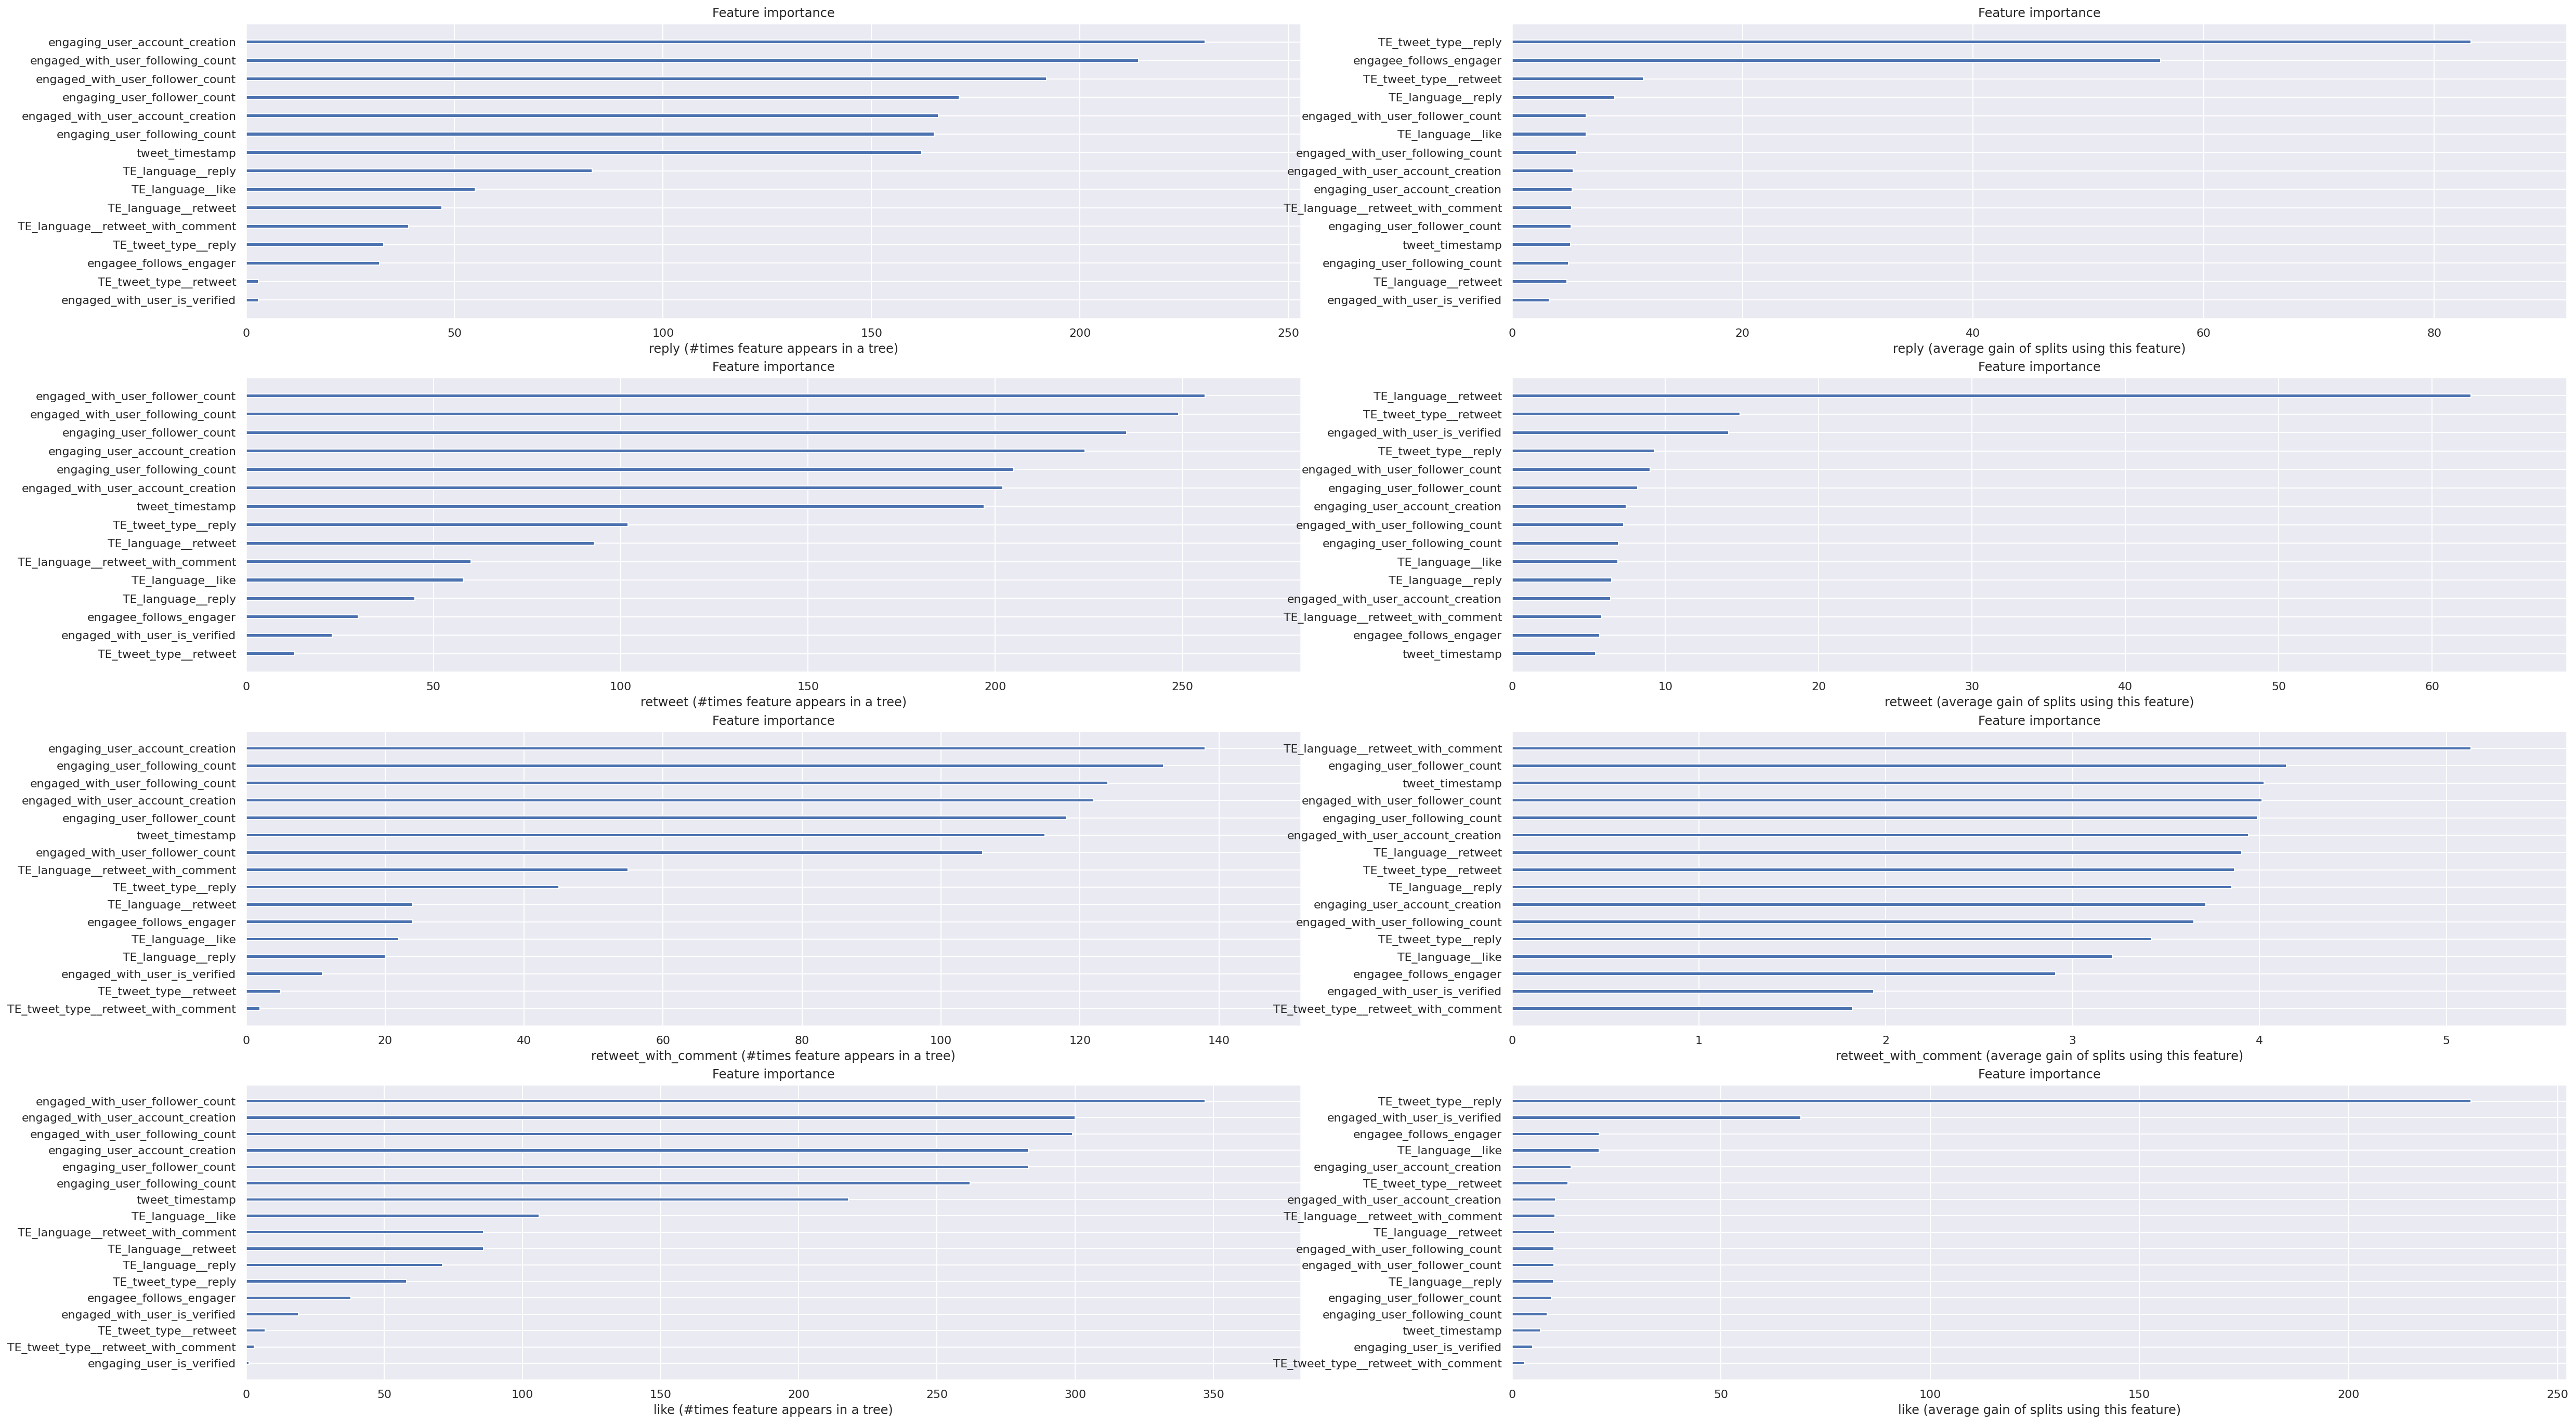

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(40, 24))
for i, (name, booster) in enumerate(cv_models[-1].items()):
    ax = axes[i][0]
    xgb.plot_importance(booster, ax, importance_type='weight', xlabel=name+' (#times feature appears in a tree)', show_values=False, ylabel=None)
for i, (name, booster) in enumerate(cv_models[-1].items()):
    ax = axes[i][1]
    xgb.plot_importance(booster, ax, importance_type='gain', xlabel=name+' (average gain of splits using this feature)', show_values=False, ylabel=None)